In [1]:
import numpy as np
import pandas as pd

dtype = {
    'id': np.int8,
    'qid1': np.int8,
    'qid2': np.int8,
    'question1': np.str,
    'question2': np.str,
    'is_duplicate': np.int8
}
train = pd.read_csv('/input/Kaggle/Quora/train.csv', dtype=dtype)
print(train.shape)
train.dropna(inplace=True)
print(train.shape)

(404290, 6)
(404288, 6)


In [2]:
dtype = {
    'test_id': np.int8,
    'question1': np.str,
    'question2': np.str
}
test = pd.read_csv('/input/Kaggle/Quora/test.csv', dtype=dtype)
print( (test.isnull()).sum().sum() )
test.replace(np.nan, '', inplace=True)
print( (test.isnull()).sum().sum() )

6
0


# 数据预处理

In [4]:
# GloVe word embeddings， 20 Newsgroup dataset, Fasttext， 
from gensim.models.word2vec import Word2Vec, KeyedVectors
word2vec = KeyedVectors.load_word2vec_format('/input/Kaggle/Word2Vec/GoogleNews-vectors-negative300.bin.gz', binary=True)

EMBEDDING_DIM = 300 # goes according to datasets

Using TensorFlow backend.


In [61]:
# from nltk.corpus import stopwords
# stopwords = set(stopwords.words('english'))
stopwords = ('i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn')

from nltk.stem.snowball import EnglishStemmer
stemmer = EnglishStemmer()

def pure(row):
    words = row.lower().split()
    new_words= []
    
    for word in words:
        if word in stopwords:
            continue
        elif word in word2vec.vocab:
            new_words.append(word)
        else:
            word_stem = stemmer.stem(word)
            if word_stem in word2vec.vocab:
                new_words.append(word_stem)

    return ' '.join(new_words)

In [62]:
a = pure("an apple has friends")
print(a)

apple friends


In [73]:
train['question1_pure'] = train['question1'].apply(pure)
train['question2_pure'] = train['question2'].apply(pure)
test['question1_pure'] = test['question1'].apply(pure)
test['question2_pure'] = test['question2'].apply(pure)

# Tokenization

In [74]:
all_unique_questions = pd.concat([train.question1_pure, train.question2_pure, 
                                   test.question1_pure,  test.question2_pure]).unique()
all_unique_questions = all_unique_questions.tolist()

In [75]:
# 预处理阶段,keras.preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_SEQ_LEN = 32 # 输入数据的最大维度，即一个句子不大可能超过32个词语，排除掉一些stop word后
NUM_WORDS = 4098 # Tokenizer的最大Word数量，常用的英文单词估计也不会超过这么多个

tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(all_unique_questions)

# 只有在调用texts_to_sequences的时候，num_words限制总vocabulary的效果才会显示出来
q1_seq = tokenizer.texts_to_sequences(train.question1)
q2_seq = tokenizer.texts_to_sequences(train.question2)
# q1_seq,类型是<class 'list'>，sample: [2, 3, 1, 1281, 57, 1281, 2846, 8, 581, 7, 751, 356, 7, 34]

q1_seq_pad = pad_sequences(q1_seq, maxlen=MAX_SEQ_LEN)
q2_seq_pad = pad_sequences(q2_seq, maxlen=MAX_SEQ_LEN)
# q1_seq_pad，类型<class 'numpy.ndarray'>, size: (404288, 32)
# sample:
# [   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
#    0    0    0    2    3    1 1281   57 1281 2846    8  581    7  751  356
#    7   34]

X1_all = q1_seq_pad.copy()
X2_all = q2_seq_pad.copy()
y_all = train.is_duplicate

# Apply for Test Dataset
q1_test_seq = tokenizer.texts_to_sequences(test.question1)
q2_test_seq = tokenizer.texts_to_sequences(test.question2)

q1_test_seq = pad_sequences(q1_test_seq, maxlen=MAX_SEQ_LEN)
q2_test_seq = pad_sequences(q2_test_seq, maxlen=MAX_SEQ_LEN)

X1_test = q1_test_seq.copy()
X2_test = q2_test_seq.copy()

In [ ]:
# type(tokenizer.word_index)<class 'dict'>
input_size = len(tokenizer.word_index) + 1 # +1是Keras Embeddings的参数要求
embedding_weights = np.zeros((input_size, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if word in word2vec.vocab:
        embedding_weights[i] = word2vec.word_vec(word)
    else:
        word_stem = stemmer.stem(word)
        if word_stem in word2vec.vocab:
            embedding_weights[i] = word2vec.word_vec(word_stem)

# 神经网络

> 结合Embeddings、共享参数模型、RNN/LSTM、一维卷积网络

In [18]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, MaxPooling1D, BatchNormalization
from keras.layers.merge import concatenate
from keras.models import Model

def get_model():
    # 1、共享参数Embedding模型
    # Turns positive integers (indexes) into dense vectors of fixed size. eg. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]
    # input_dim: int > 0. Size of the vocabulary, i.e. maximum integer index + 1.
    # output_dim: int >= 0. Dimension of the dense embedding
    # input_length: Length of input sequences, when it is constant. This argument is required if you are going to connect 
    #               Flatten then Dense layers upstream (without it, the shape of the dense outputs cannot be computed).
    shared_embedding = Embedding(input_dim=input_size, output_dim=EMBEDDING_DIM, input_length=MAX_SEQ_LEN,
                                weights=[embedding_weights], trainable=False)

    # 2、共享参数卷积模型，可以提取出更高层，更抽象的信息。不过实践后，效果欠佳
#     conv_input = Input(shape=(MAX_SEQ_LEN, EMBEDDING_DIM))#try, shape. dtype='int32'
#     x = Conv1D(filters=64, kernel_size=5, strides=1, padding='valid', activation='relu')(conv_input)
#     conv_output = MaxPooling1D(4)(x)
#     shared_conv = Model(inputs=conv_input, outputs=conv_output)

    # 3、共享参数LSTM模型
    # units: Positive integer, dimensionality of the output space
    shared_lstm = LSTM(units=EMBEDDING_DIM, dropout=0.2, recurrent_dropout=0.2)
    
    # 双层LSTM，训练变慢了很多，效果也没有提升太多
#     lstm_input = Input(shape=(MAX_SEQ_LEN, EMBEDDING_DIM))
#     # return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
#     x = LSTM(units=EMBEDDING_DIM, return_sequences=True)(lstm_input)
#     lstm_output = LSTM(units=128)(x)
#     shared_lstm = Model(inputs=lstm_input, outputs=lstm_output)

    # 开始构建模型
    q1_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32', name='input_1')
    q2_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32', name='input_2')

    x1 = shared_embedding(q1_input)
    x2 = shared_embedding(q2_input)

#     x1 = shared_conv(x1)
#     x2 = shared_conv(x2)

    x1 = shared_lstm(x1)
    x2 = shared_lstm(x2)

    x = concatenate([x1, x2], name='concatenate')
    #x = Dropout(0.5, name='Dropout_1')(x)
    #x = BatchNormalization(name='Norm_1')(x)
    x = Dense(128, activation='relu', name='Dense_1')(x)
    x = Dropout(0.5, name='Dropout_2')(x)
    # x = BatchNormalization(name='Norm_2')(x)
    out = Dense(1, activation='sigmoid', name='Dense_2')(x)

    model = Model(inputs=[q1_input, q2_input], outputs=out)
    # 在 0-1 Classification问题中，binary_crossentropy和logloss等价
    model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['binary_accuracy'])

#     model.summary()
    
    return model

In [86]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

# reset，因为Keras还没实现model.reset()重置weight的功能，不过作者说在做
model = get_model()

run = 10
LOG_DIR = '/output/training_logs/run{}'.format(run)
EPOCHS = 64 #等待early stopping
BATCH_SIZE = 128
VAL_SPLIT = 0.3

tensorboard = TensorBoard(log_dir=LOG_DIR, write_images=True)
checkpoint = ModelCheckpoint(filepath=LOG_DIR+"/checkpoint-{epoch:02d}-{val_loss:.4f}.hdf5", 
                            verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

his = model.fit([X1_all, X2_all], y_all, 
                epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT,
                shuffle=True, verbose=1,
                callbacks=[tensorboard, checkpoint, early_stopping])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32)            0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 32)            0                                            
____________________________________________________________________________________________________
embedding_22 (Embedding)         (None, 32, 300)       16284600    input_1[0][0]                    
                                                                   input_2[0][0]                    
____________________________________________________________________________________________________
model_29 (Model)                 (None, 128)           940848      embedding_22[0][0]      

KeyboardInterrupt: 

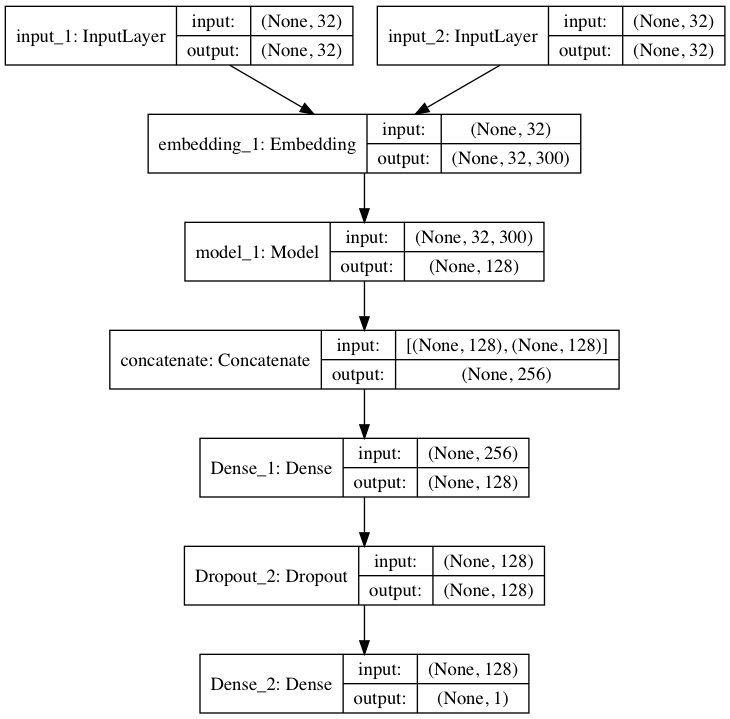

In [20]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model, to_file="./assets/quora-nn-model.png", show_shapes=True)
Image('./assets/quora-nn-model.png')